In [1]:
%load_ext lab_black
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import glob
import tqdm
import umap
import lightgbm as lgb
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

from utils import DATA_SETS, gather_df, prepare_df

In [73]:
results = []

for dataset in DATA_SETS[2:3]:
    for w_attempt in range(10):
        df = gather_df(dataset, True)
        n_feats = (
            len([c for c in df.columns if "ws10m_max" in c])
            + len([c for c in df.columns if "rainfall" in c])
            + len([c for c in df.columns if "temperature" in c])
        )
        location_array_W = np.random.normal(0, 1, n_feats)
        df = prepare_df(df, True, True, True, location_array_W)

        for target_col in [c for c in df.columns if "target" in c]:
            for pred_ahead in tqdm.tqdm([14, 28, 56]):
                y = df[target_col].pct_change(pred_ahead).shift(-pred_ahead)

                available_indexes = df.index[~pd.isna(y)]
                train_split = available_indexes[int(len(available_indexes) * 0.7)]
                val_split = available_indexes[int(len(available_indexes) * 0.85)]

                # add pred_ahead here because at time t, we do not know what the target variable will do in the future
                test_split_start = available_indexes[
                    int(len(available_indexes) * 0.85) + pred_ahead
                ]

                X_train = df[(df.index <= train_split)]
                X_val = df[(df.index > train_split) & (df.index < val_split)]
                X_test = df[(df.index >= test_split_start)]

                y_train = y[(df.index <= train_split)]
                # log transform y_train to reduce long tail effects and np.clip just to be safe
                y_train = np.log(np.clip(y_train, -1, 100) + 1)

                y_val = y[(df.index > train_split) & (df.index < val_split)]
                y_val = np.log(np.clip(y_val, -1, 100) + 1)

                y_test = y[(df.index >= test_split_start)]

                X_train = X_train[~pd.isna(y_train)]
                y_train = y_train[~pd.isna(y_train)]

                rmodel = lgb.LGBMRegressor(early_stopping_rounds=100)
                rmodel.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)
                dfp_test = pd.DataFrame(
                    {
                        "p": np.exp(rmodel.predict(X_test)) - 1,
                        "y": y_test,
                        "original": df[target_col][(df.index > test_split_start)],
                    }
                )
                # since we used percentages as targets, we need to reverse this to be able to compute objective scores
                dfp_test["y"] = (dfp_test.y + 1) * dfp_test.original
                dfp_test["p"] = (dfp_test.p + 1) * dfp_test.original

                dfp_test = dfp_test[~pd.isna(dfp_test.y)]
                mae = np.mean(np.abs(dfp_test.p - dfp_test.y))
                rmse = np.sqrt(np.mean(dfp_test.p - dfp_test.y) ** 2)

                dfp_val = pd.DataFrame(
                    {
                        "p": np.exp(rmodel.predict(X_val)) - 1,
                        "y": y_val,
                        "original": df[target_col][
                            (df.index > train_split) & (df.index < val_split)
                        ],
                    }
                )
                dfp_val["y"] = (dfp_val.y + 1) * dfp_val.original
                dfp_val["p"] = (dfp_val.p + 1) * dfp_val.original

                dfp_val = dfp_val[~pd.isna(dfp_val.y)]
                mae_val = np.mean(np.abs(dfp_val.p - dfp_val.y))
                rmse_val = np.sqrt(np.mean(dfp_val.p - dfp_val.y) ** 2)

                results.append(
                    {
                        "dataset": dataset,
                        "mae_val": mae_val,
                        "rmse_val": rmse_val,
                        "mae": mae,
                        "rmse": rmse,
                        "W": location_array_W,
                        "pred_ahead": pred_ahead,
                        "target_col": target_col,
                    }
                )

    pd.DataFrame(results).to_json("./simres-umap-actual-log.json")

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


  0%|          | 0/3 [00:00<?, ?it/s]/home/opt/anaconda/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/opt/anaconda/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/opt/anaconda/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


 33%|███▎      | 1/3 [00:00<00:00,  2.46it/s]

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


 67%|██████▋   | 2/3 [00:00<00:00,  2.50it/s]

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


  0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


 33%|███▎      | 1/3 [00:00<00:00,  2.65it/s]

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


 67%|██████▋   | 2/3 [00:00<00:00,  2.62it/s]

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


In [75]:
dfr = pd.DataFrame(results)
dfr.sort_values("mae_val")

,dataset,mae_val,rmse_val,mae,rmse,W,pred_ahead,target_col
21,aquifer_petrignano,0.208185,0.038828,0.184050,0.007017,"[0.18958278677177065, 0.526771605048818, -0.53...",14,target_depth_to_groundwater_p25
33,aquifer_petrignano,0.211272,0.039765,0.179240,0.001988,"[-1.6616202447043293, -0.025926445931585433, 0...",14,target_depth_to_groundwater_p25
3,aquifer_petrignano,0.211441,0.040813,0.188767,0.009400,"[1.0294934305913732, 0.0722883440173681, 1.525...",14,target_depth_to_groundwater_p25
15,aquifer_petrignano,0.211902,0.042588,0.188406,0.000105,"[0.32739994724461824, 0.16218938853293902, -1....",14,target_depth_to_groundwater_p25
51,aquifer_petrignano,0.211989,0.038840,0.178439,0.001888,"[-1.1578868791981431, 0.15589287577034108, 0.1...",14,target_depth_to_groundwater_p25
45,aquifer_petrignano,0.212062,0.033657,0.179437,0.009040,"[-0.5192847742651318, -1.5629371741375828, 2.0...",14,target_depth_to_groundwater_p25
57,aquifer_petrignano,0.212241,0.043589,0.181013,0.002079,"[0.05750100898193965, -0.12313014261827475, 1....",14,target_depth_to_groundwater_p25
9,aquifer_petrignano,0.212711,0.038594,0.181037,0.004919,"[-1.2539365373648266, 0.0707534795611405, -0.7...",14,target_depth_to_groundwater_p25
27,aquifer_petrignano,0.212804,0.037167,0.183000,0.005170,"[0.4834862230641554, 0.09555062902468084, 0.42...",14,target_depth_to_groundwater_p25
39,aquifer_petrignano,0.214196,0.034006,0.179068,0.005685,"[-0.0852793526501951, -0.19065143527559303, -1...",14,target_depth_to_groundwater_p25


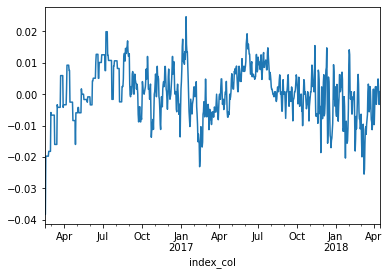

In [60]:
y_val.plot()

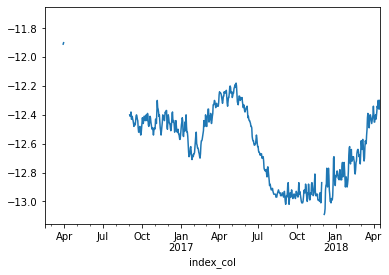

In [59]:
dfp_val.original.plot()